In [1]:
# %matplotlib inline
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F
from utils import euclidean_metric,count_acc,savemodel,loadmodel,getItems
import matplotlib.pyplot as plt
import logging,os
import argparse
from tensorboard_logger import configure, log_value


%load_ext autoreload
%autoreload 2
torch.manual_seed(42)
np.random.seed(42)

from ADOS_data import ADOS_dataset,Siamese_dataset,Baseline_backprop_dataset
from samplers import CategorySampler,SiameseSampler
from net import Siamese
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('always')

In [2]:
def valid_siamese(model,test_dl,child_c,adult_c):
    tr_loss=0
    count=0
    tr_acc=0
    fscore=0
    child_c=child_c.reshape(1,-1)
    adult_c=adult_c.reshape(1,-1)
    for i,batch in enumerate(test_dl,1):
        data,label = [_.cpu() for _ in batch]
        child_vec=child_c.expand(data.shape[0],-1)
        adult_vec=adult_c.expand(data.shape[0],-1)
        logits_child = model(data,child_vec)
        logits_adult = model(data,adult_vec)
        logits=torch.stack((logits_child,logits_adult),dim=1)
        pred=torch.argmax(logits,dim=1)
        logits=torch.max(logits,dim=1).values
        loss = criteria(logits,label)

        acc=(pred == label.long()).type(torch.FloatTensor).mean().item()
        
        count+=1
        tr_loss+=loss.item()
        tr_acc+=acc
        logits=None; loss=None
            
    return tr_loss/count,tr_acc/count

In [3]:
def test_siamese(model,test_dl,child_c,adult_c):
    tr_loss=0
    count=0
    tr_acc=0
    fscore=0
    child_c=child_c.reshape(1,-1)
    adult_c=adult_c.reshape(1,-1)
    for i,batch in enumerate(test_dl,1):
        data,label = [_.cpu() for _ in batch]
        child_vec=child_c.expand(data.shape[0],-1)
        adult_vec=adult_c.expand(data.shape[0],-1)
        logits_child = model(data,child_vec)
        logits_adult = model(data,adult_vec)
        logits=torch.stack((logits_child,logits_adult),dim=1)
        pred=torch.argmax(logits,dim=1)
        logits=torch.max(logits,dim=1).values
        loss = criteria(logits,label)

        acc=(pred == label.long()).type(torch.FloatTensor).mean().item()
        
        count+=1
        tr_loss+=loss.item()
        tr_acc+=acc
        logits=None; loss=None
            
    return tr_loss/count,tr_acc/count



In [4]:
def valid(model,train_dl,device='cpu'):
    tr_loss=0
    count=0
    tr_acc=0
    for i,batch in enumerate(train_dl,1):                
        
        b,_ = [_.to(device) for _ in batch]
        bs=b.shape[0]//2

        child=b[:bs]
        adult=b[bs:]
        inp1=torch.cat([child[:bs//4],adult[:bs//4],child[bs//4:-bs//4]],dim=0)
        inp2=torch.cat([child[-bs//4:],adult[bs//4:]],dim=0)
        label=torch.FloatTensor([1]*(bs//2)+[0]*(bs//2))
        
        select=torch.randperm(64)
        inp1,inp2,label=inp1[select],inp2[select],label[select]
        
        logits = model(inp1,inp2)
        loss = criteria(logits,label)

        correct=((logits.sigmoid()>0.5).long()==label.long())
        acc=correct.type(torch.FloatTensor).mean().item()
        
        tr_acc+=acc
        count+=1
        tr_loss+=loss.item()        
        proto=None; logits=None; loss=None
        
    return tr_loss/count,tr_acc/count

In [5]:
def fit(model,train_dl,device='cpu'):
    tr_loss=0
    count=0
    tr_acc=0
    for i,batch in enumerate(train_dl,1):                
        
        b,_ = [_.to(device) for _ in batch]
        bs=b.shape[0]//2

        child=b[:bs]
        adult=b[bs:]
        inp1=torch.cat([child[:bs//4],adult[:bs//4],child[bs//4:-bs//4]],dim=0)
        inp2=torch.cat([child[-bs//4:],adult[bs//4:]],dim=0)
        label=torch.FloatTensor([1]*(bs//2)+[0]*(bs//2))
        
        select=torch.randperm(64)
        inp1,inp2,label=inp1[select],inp2[select],label[select]
        
        logits = model(inp1,inp2)
        loss = criteria(logits,label)

        correct=((logits.sigmoid()>0.5).long()==label.long())
        acc=correct.type(torch.FloatTensor).mean().item()
        
        tr_acc+=acc
        count+=1
        tr_loss+=loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        proto=None; logits=None; loss=None
        
    return tr_loss/count,tr_acc/count

In [6]:
sessions="abreja acosal1 acosal2 almaja1 almaja2 beamja behpan1 behpan2 caccev1 caccev2 carema einstein03 einstein04 einstein06 einstein08 idmssm28 idmssm51 idmssm78 latody nyu30085 nyu40014 nyu40015 nyu40017 nyu4696b nyu600391 nyu600392 pellda"
sessions=sessions.split()

n_train_sess=18
n_classes=2
n_wavs=64 #64/2
sess_count=0
test_epochs=1
start=0
for fold in range(9):
# fold=0
    train_ds=Siamese_dataset(fold,'train')
    train_bs=SiameseSampler(train_ds.label,n_train_sess,
                             n_classes,n_wavs)
    train_dl=DataLoader(train_ds,batch_sampler=train_bs,num_workers=6)
    
    valid_ds=Siamese_dataset(fold,'val')
    train_bs=SiameseSampler(valid_ds.label,6,
                             n_classes,n_wavs)
    valid_dl=DataLoader(valid_ds,batch_sampler=train_bs,num_workers=6)

    device='cpu'
    model = Siamese(128,64,16)
    optimizer=torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=0.0)
    criteria=torch.nn.BCEWithLogitsLoss()
    # criteria=ContrastiveLoss()
    model.to(device)

    n_epochs=100
    id=5
    min_loss=float('Inf')
    for epoch in range(1,n_epochs+1):
        model.train()
        tr_loss,tr_acc=fit(model,train_dl)
        model.eval()
        val_loss,val_acc=valid(model,valid_dl)
        if val_loss<min_loss:
            savemodel(fold,model,baseline=False,dir='siamese')
            min_loss=val_loss
        if epoch%id==0:
            print("fold {} loss {:.3f} acc {:.3f}".format(fold,tr_loss,tr_acc))

saved model
saved model
saved model
saved model
fold 0 loss 1.339 acc 0.528
saved model
saved model
fold 0 loss 1.116 acc 0.524
saved model
saved model
saved model
saved model
fold 0 loss 0.888 acc 0.582
saved model
saved model
fold 0 loss 0.775 acc 0.598
saved model
fold 0 loss 0.761 acc 0.618
fold 0 loss 0.712 acc 0.627
saved model
fold 0 loss 0.657 acc 0.648
fold 0 loss 0.642 acc 0.657
saved model
fold 0 loss 0.614 acc 0.680
fold 0 loss 0.586 acc 0.694
saved model
fold 0 loss 0.584 acc 0.699
saved model
fold 0 loss 0.540 acc 0.718
fold 0 loss 0.535 acc 0.743
fold 0 loss 0.512 acc 0.751
fold 0 loss 0.512 acc 0.761
fold 0 loss 0.489 acc 0.776
fold 0 loss 0.453 acc 0.791
fold 0 loss 0.427 acc 0.821
fold 0 loss 0.473 acc 0.799
fold 0 loss 0.457 acc 0.795
saved model
saved model
saved model
saved model
fold 1 loss 1.166 acc 0.511
saved model
saved model
saved model
fold 1 loss 0.954 acc 0.553
saved model
saved model
fold 1 loss 0.795 acc 0.590
fold 1 loss 0.762 acc 0.588
fold 1 loss 0.71

In [7]:
# sessions="abreja acosal1 acosal2 almaja1 almaja2 beamja behpan1 behpan2 caccev1 caccev2 carema einstein03 einstein04 einstein06 einstein08 idmssm28 idmssm51 idmssm78 latody nyu30085 nyu40014 nyu40015 nyu40017 nyu4696b nyu600391 nyu600392 pellda"
# sessions=sessions.split()

# n_train_sess=18
# n_classes=2
# n_wavs=64 #64/2
# sess_count=0
# test_epochs=1
# start=0
# for fold in range(9):
# # fold=0
#     train_ds=Siamese_dataset(fold,'train')
#     train_bs=SiameseSampler(train_ds.label,n_train_sess,
#                              n_classes,n_wavs)
#     train_dl=DataLoader(train_ds,batch_sampler=train_bs,num_workers=6)

#     device='cpu'
#     model = Siamese(128,64,32)
#     optimizer=torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=0.0)
#     criteria=torch.nn.BCEWithLogitsLoss()
#     # criteria=ContrastiveLoss()
#     model.to(device)

#     n_epochs=40
#     id=5
#     min_loss=float('Inf')
#     for epoch in range(1,n_epochs+1):
#         model.train()
#         tr_loss,tr_acc=fit(model,train_dl)
#         model.eval()
#         temp_loss,temp_acc=[],[]
#         for val_sess in getItems(list(range(27)),start,6):
#             test_ds=Baseline_backprop_dataset(sessions[sess_count])
#             test_dl=DataLoader(test_ds,batch_size=10,shuffle=False,drop_last=True,num_workers=4)
#             samples=iter(test_dl)
#             data,_=next(samples)
#             child_c=data[:5].mean(dim=0)
#             adult_c=data[:5].mean(dim=0)
#             val_loss,val_acc=valid_siamese(model,samples,child_c,adult_c)
#             temp_loss+=[val_loss]
#             temp_acc+=[val_acc]
#         start+=3
#         val_loss,val_acc=sum(temp_loss)/6,sum(temp_acc)/6
#         if val_loss<min_loss:
#             savemodel(fold,model,baseline=False,dir='siamese')
#             min_loss=val_loss
#         if epoch%id==0:
#             print(tr_loss,tr_acc)
    
#     model=loadmodel(fold,baseline=False,dir='siamese')
#     sess_acc=np.zeros((1,n_test_sess))
#     sess_loss=np.zeros((1,n_test_sess))
#     for i in range(3):
#         t_loss,t_acc=[],[]
#         for epoch in range(test_epochs):
#             test_ds=Baseline_backprop_dataset(sessions[sess_count])
#             test_dl=DataLoader(test_ds,batch_size=10,shuffle=False,drop_last=True,num_workers=4)
#             samples=iter(test_dl)
#             data,_=next(samples)
#             child_c=data[:5].mean(dim=0)
#             adult_c=data[:5].mean(dim=0)
#             sess_loss,sess_acc=test_siamese(model,samples,child_c,adult_c)
#             t_loss+=[sess_loss]
#             t_acc+=[sess_acc]
#         sess_acc[]
#         print(fold,sess_acc)
#         sess_count+=1

In [16]:
import torch
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
from utils import loadmodel,getItems

import os

%matplotlib inline
import matplotlib.pyplot as plt

sessions = "BARDKY GRANMI GRISRE KRXXWY MATXCO".split()
# PALUNO POMMRO ROSEMA SCHWSH SWIELI TOWXRY

ROOT='/home/coder/nithin/code/neural_data/boscc_csvs/sessions/'
red = ['#CD5C5C',"#FF0000","#FF4500","#FFA07A","#DB7093"]
blue = ['#6495ED',"#6A5ACD","#0000FF","#B0E0E6","#4169E1"]

for rand in range(1):
    for fold in range(1):
        sess_count=0
        print(fold)
        tfname='new_B_128_train_shot_20_test_shot_5_train_epochs_200_test_epochs_1_beta_0.0'
        model = loadmodel(fold,baseline=False,dir=tfname)

        X_data=[]
        raw_data=[]
        Y_data=[]
        idx=0

        start=(fold*30+240)%270
        sess_count=0
        for sess in range(5):
            csv=ROOT+sessions[sess_count]+'.csv'
            t_data=[]
            with open(csv,'r') as f:
                for line in f.readlines():
                    name,speaker=line.split(',')
                    label=idx if speaker.split('_')[0]=='child' else idx+1
                    raw_data.append(np.load(name))
                    t_data.append(np.load(name))
                    Y_data.append(label)


            model.eval()
            for i in t_data:
                out=model(torch.from_numpy(i).unsqueeze(0))
                out=out.view(-1).detach().numpy()
                X_data.append(out)

            sess_count+=1
            idx+=2

        assert len(X_data) == len(Y_data)
        Y_data=np.asarray(Y_data)
        X_data=np.asarray(X_data)


        X_embedded=TSNE(n_components=2,perplexity=20).fit_transform(X_data)

        child_ids=[[]]*len(sessions)
        adult_ids=[[]]*len(sessions)

        child_embeddings=[[]]*len(sessions)
        adult_embeddings=[[]]*len(sessions)

        idx=0
        for i in range(len(sessions)):
            child_ids[i]=np.argwhere(Y_data==idx)
            adult_ids[i]=np.argwhere(Y_data==idx+1)

            child_embeddings[i]=X_embedded[child_ids[i]].reshape(-1,2)
            adult_embeddings[i]=X_embedded[adult_ids[i]].reshape(-1,2)
            idx+=2

        fig=plt.figure(figsize=(16,6))
        plt.subplot(1,2,1)
        for i in range(len(sessions)):
            plt.scatter(child_embeddings[i][:,0],child_embeddings[i][:,1],c=red[i])
            plt.scatter(adult_embeddings[i][:,0],adult_embeddings[i][:,1],c=blue[i])
        plt.legend(['child','psych'])
        plt.title('proto'.format(fold))

        X_embedded=TSNE(n_components=2,perplexity=40).fit_transform(raw_data)
        idx=0
        for i in range(len(sessions)):
            child_ids[i]=np.argwhere(Y_data==idx)
            adult_ids[i]=np.argwhere(Y_data==idx+1)

            child_embeddings[i]=X_embedded[child_ids[i]].reshape(-1,2)
            adult_embeddings[i]=X_embedded[adult_ids[i]].reshape(-1,2)
            idx+=2

        plt.subplot(1,2,2)
        for i in range(len(sessions)):
            plt.scatter(child_embeddings[i][:,0],child_embeddings[i][:,1],c=red[i])
            plt.scatter(adult_embeddings[i][:,0],adult_embeddings[i][:,1],c=blue[i])
        plt.legend(['child','psych'])
        plt.title('x-vector'.format(fold))
#         plt.savefig('tsne/new/perplex_{}_{}_fold_{}_rand_{}.png'.format(40,40,fold,sess_count,rand))
#         plt.show()

In [22]:
idx

6

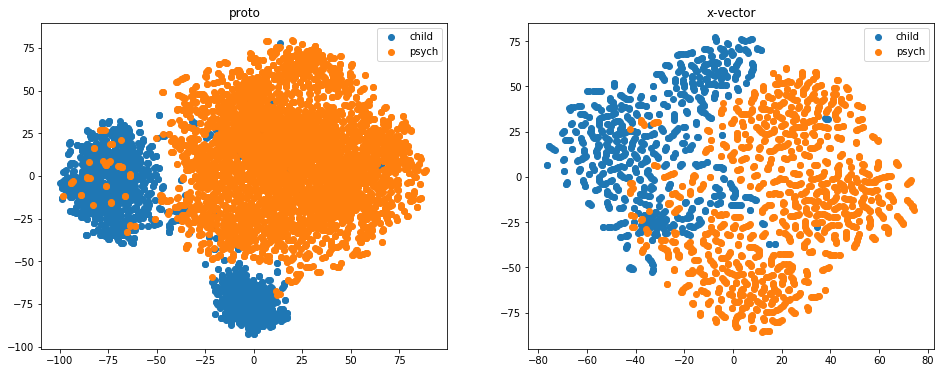

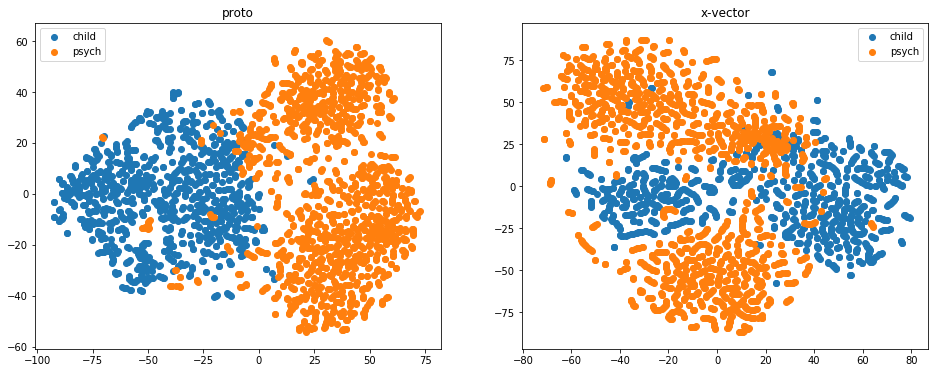

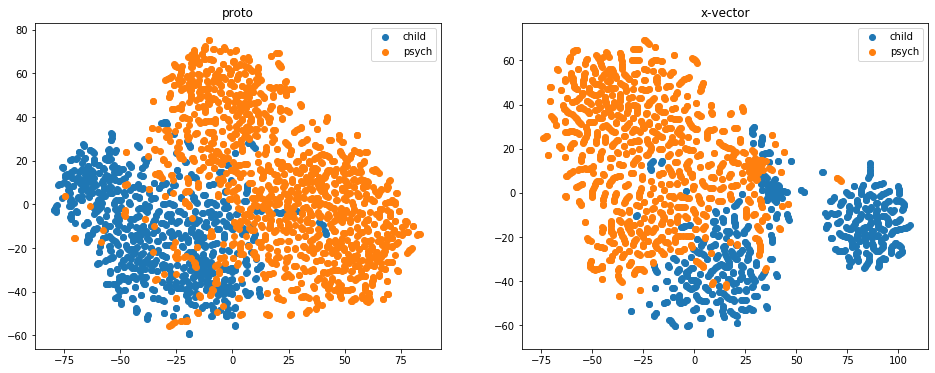

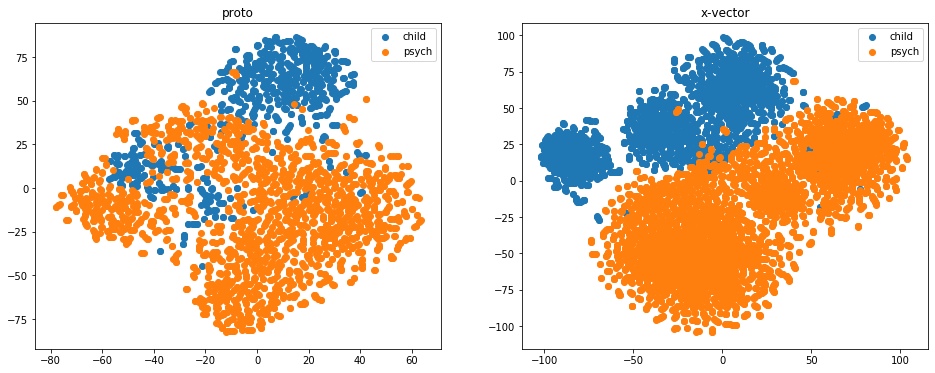

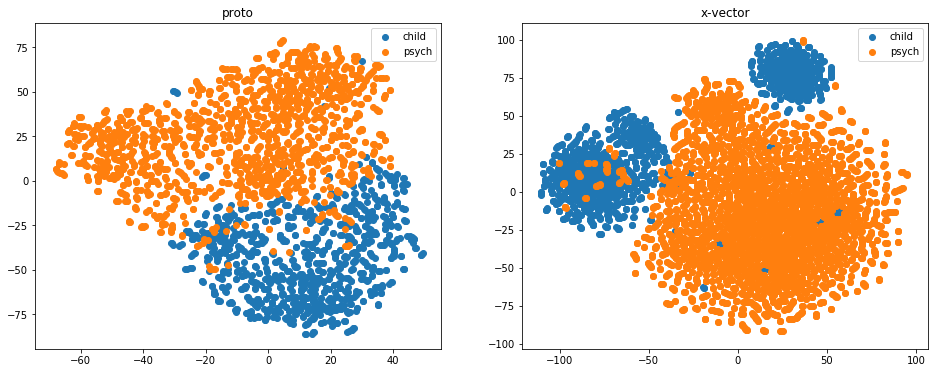

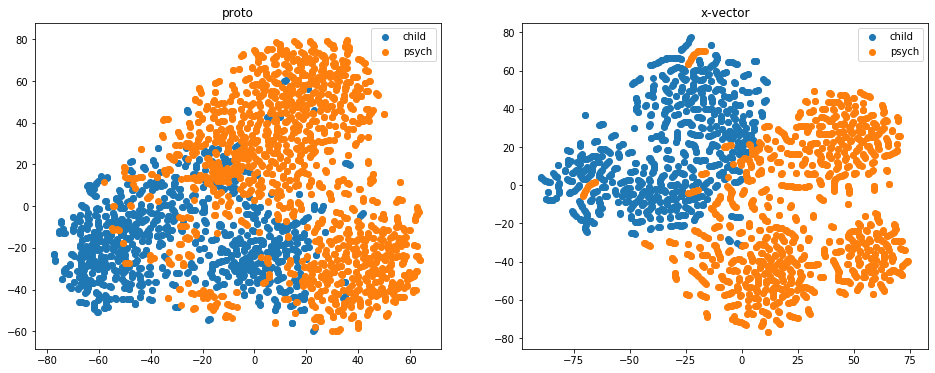

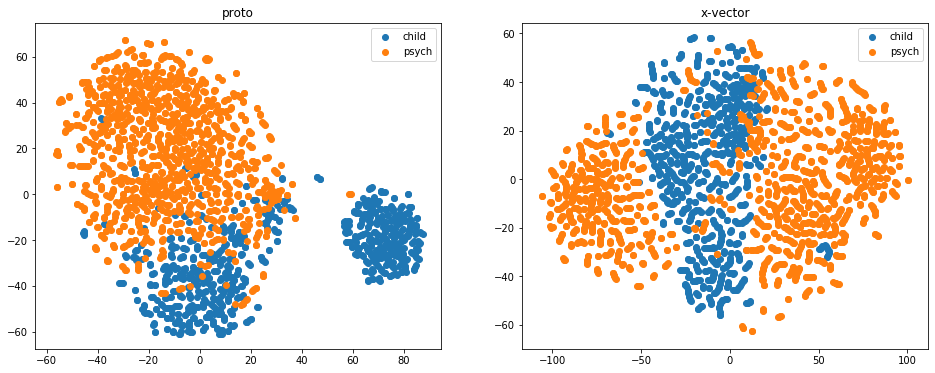

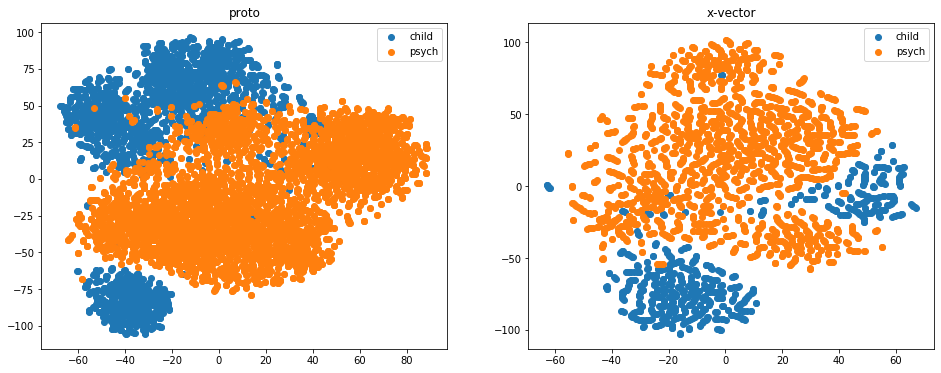

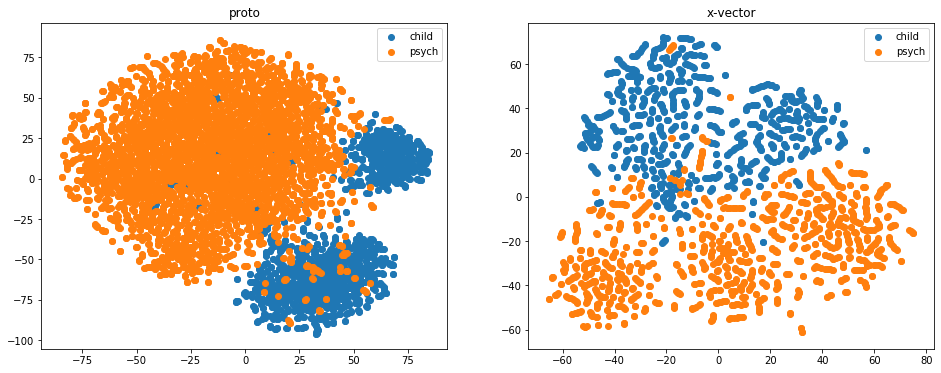

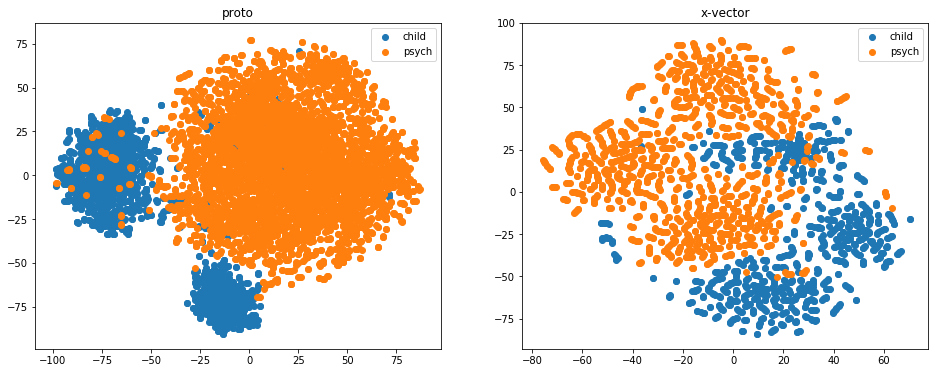

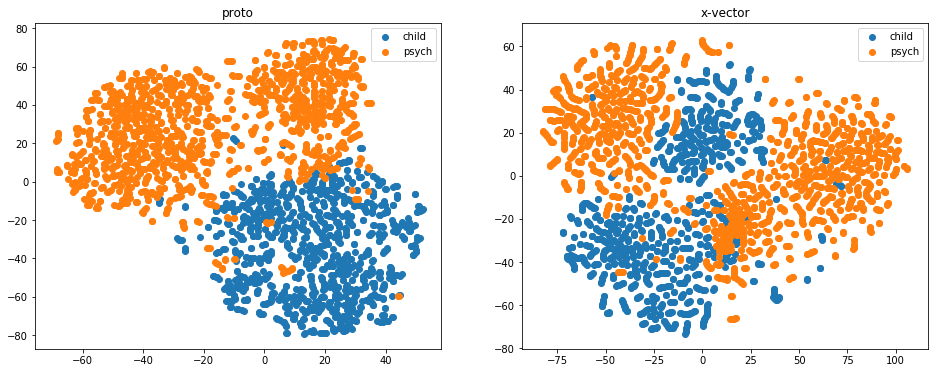

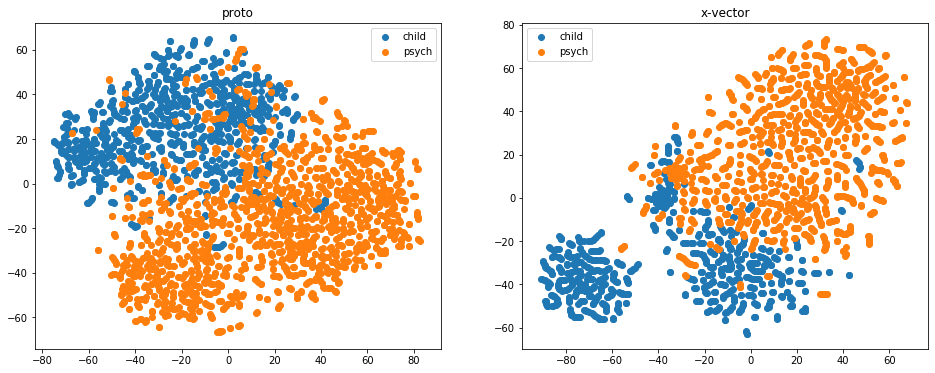

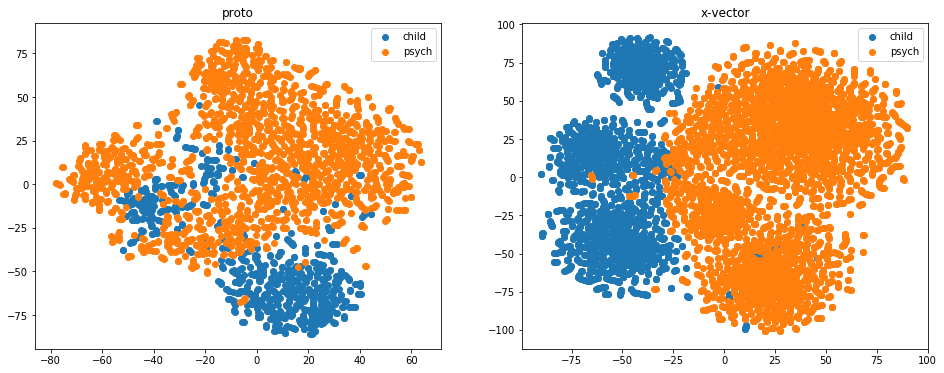

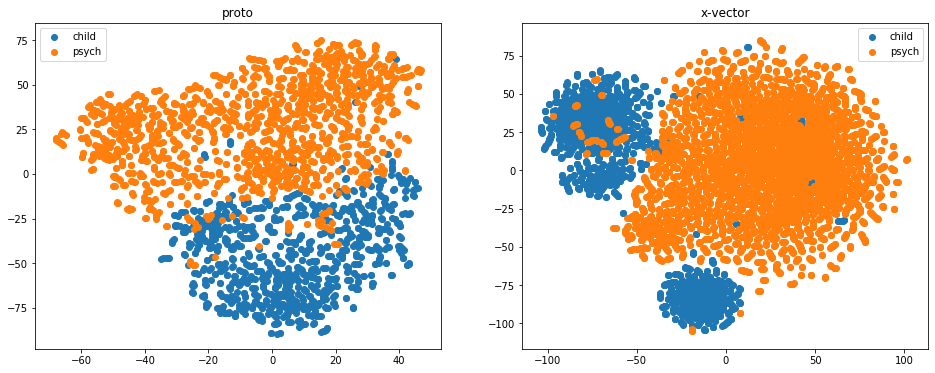

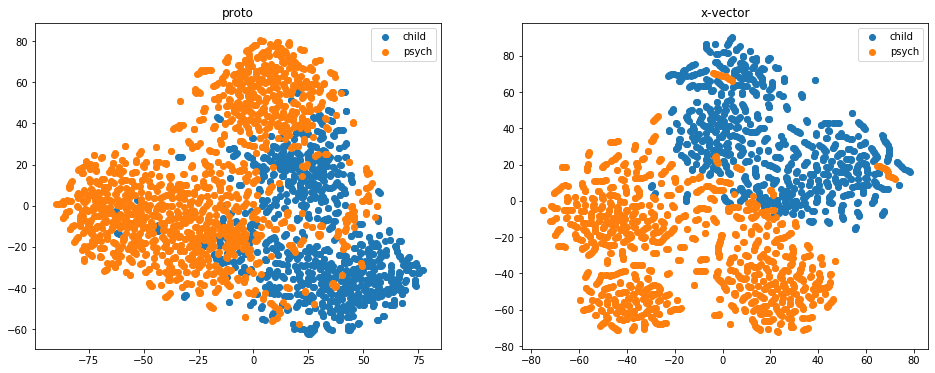

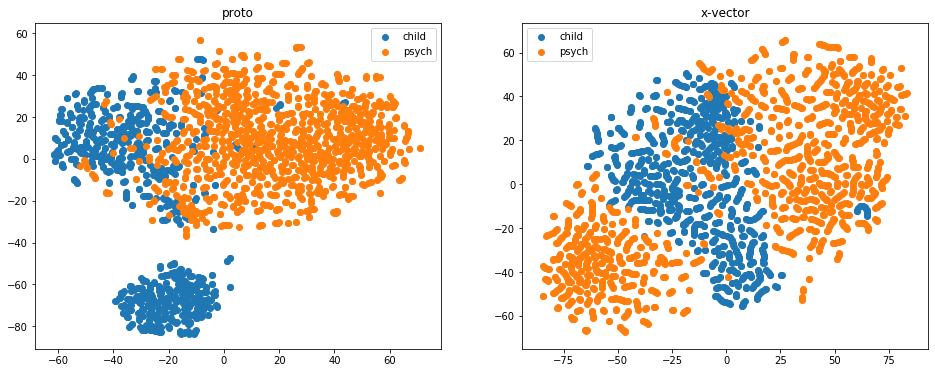

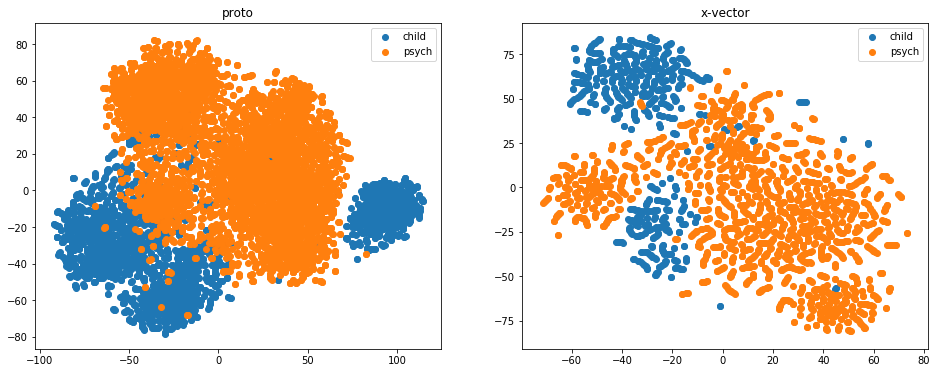

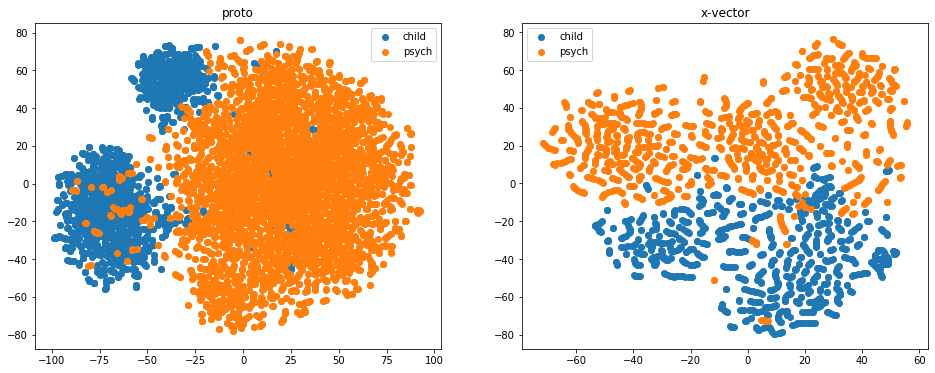

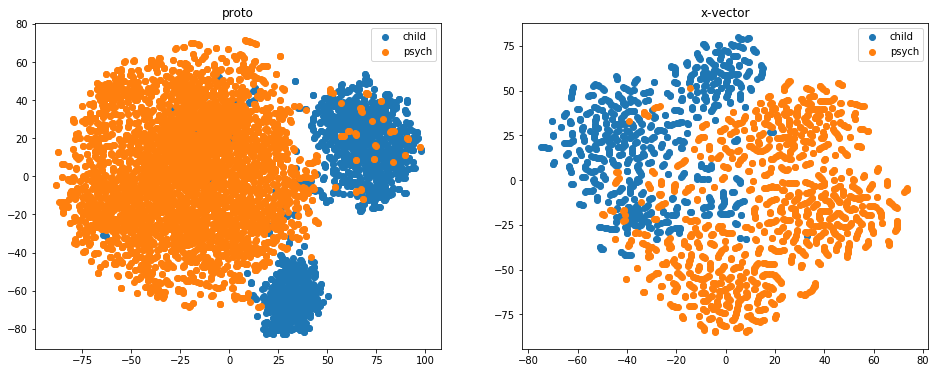

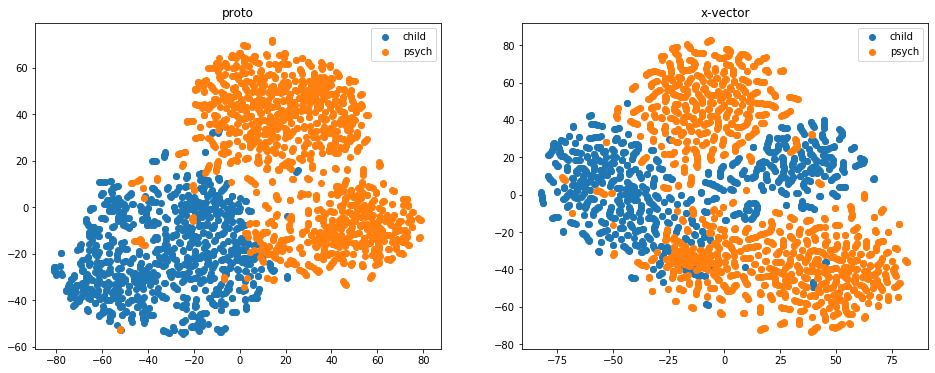

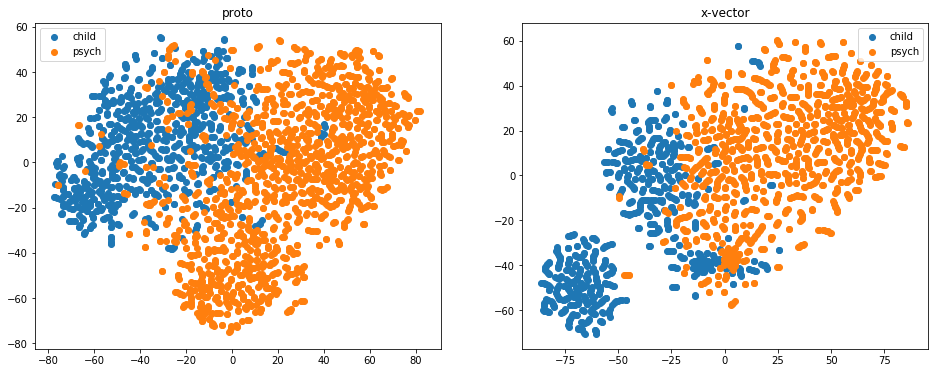

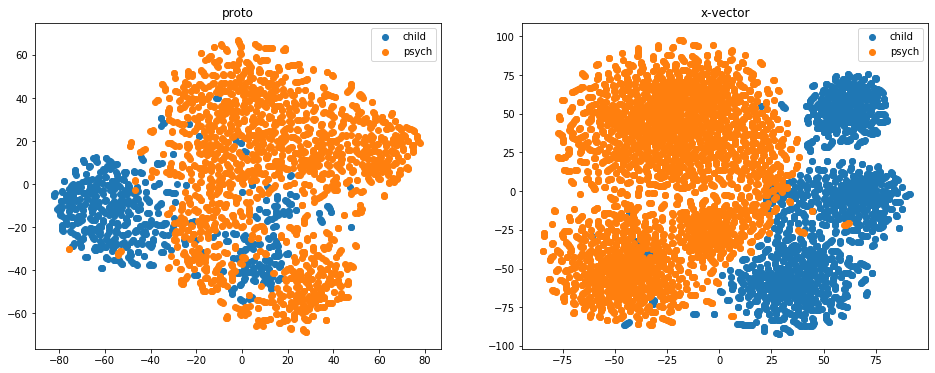

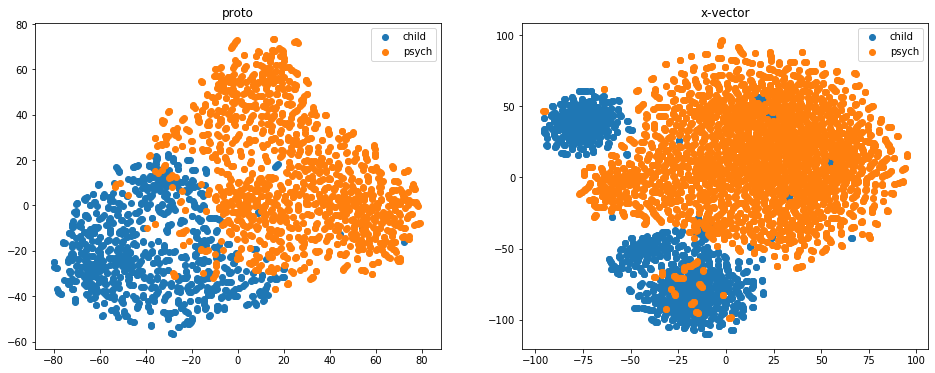

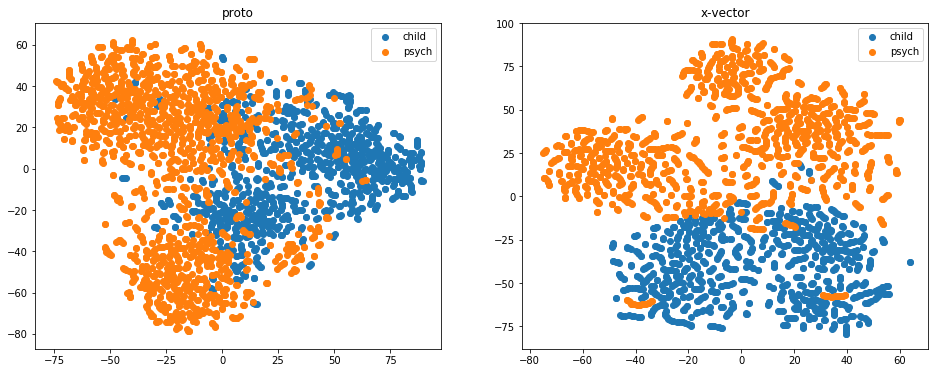

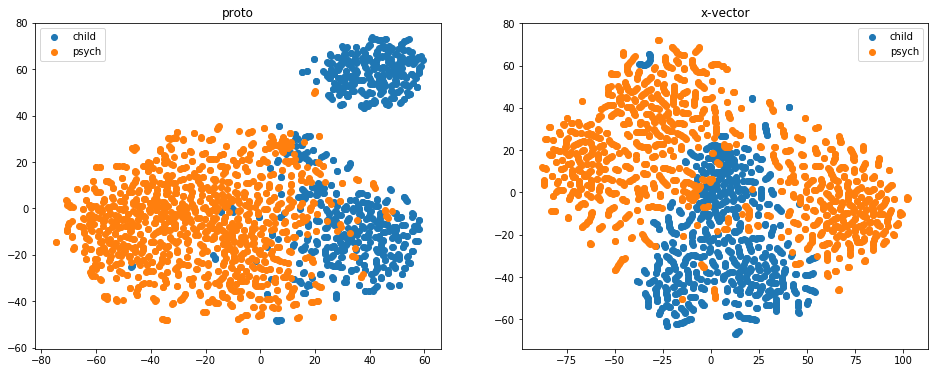

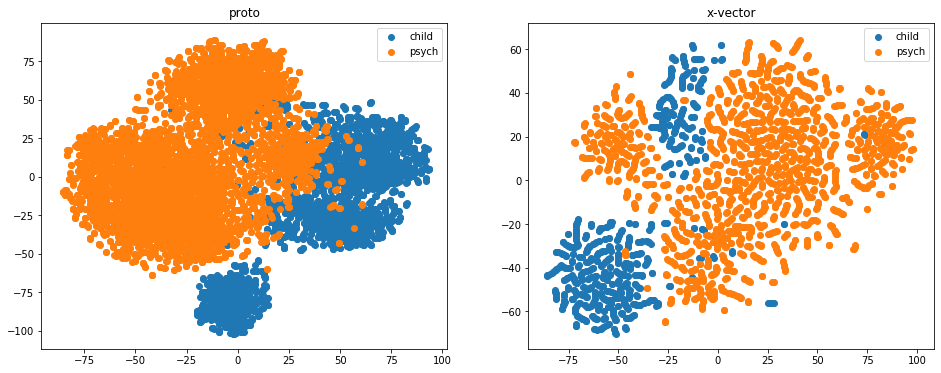

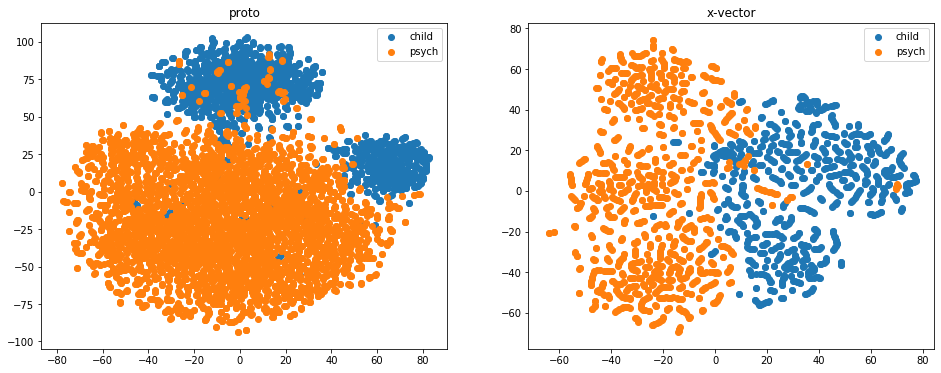

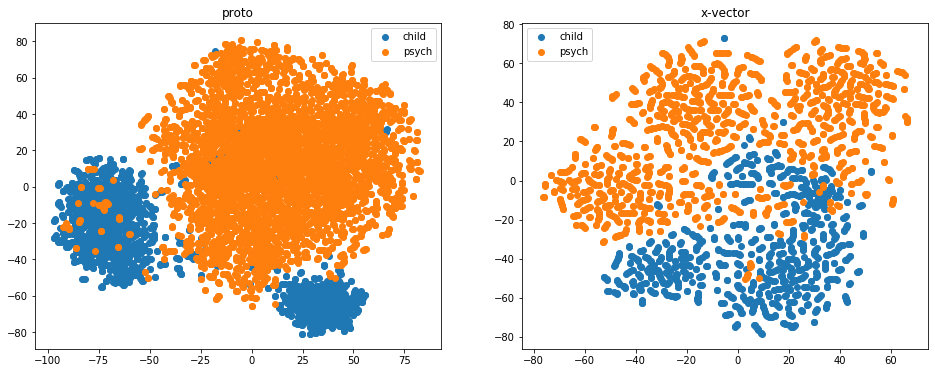

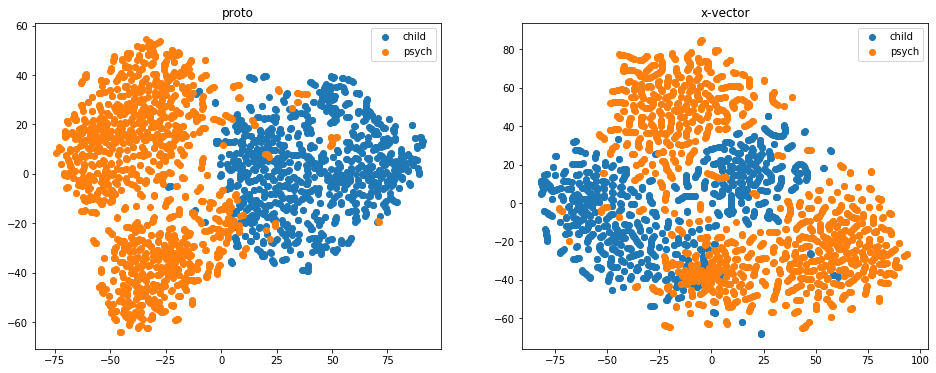

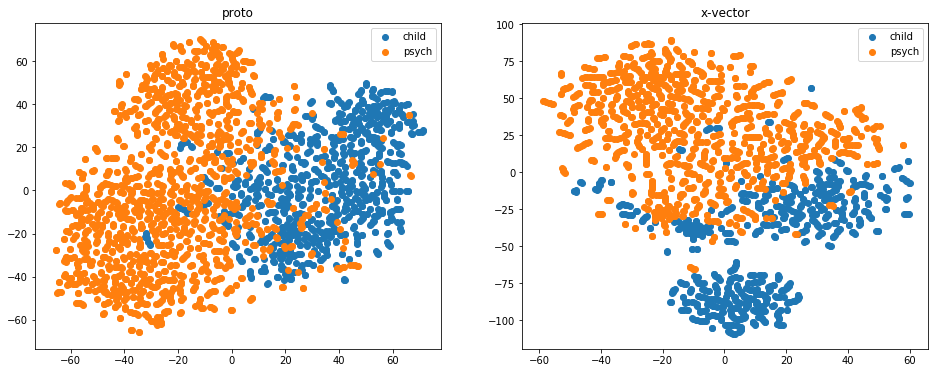

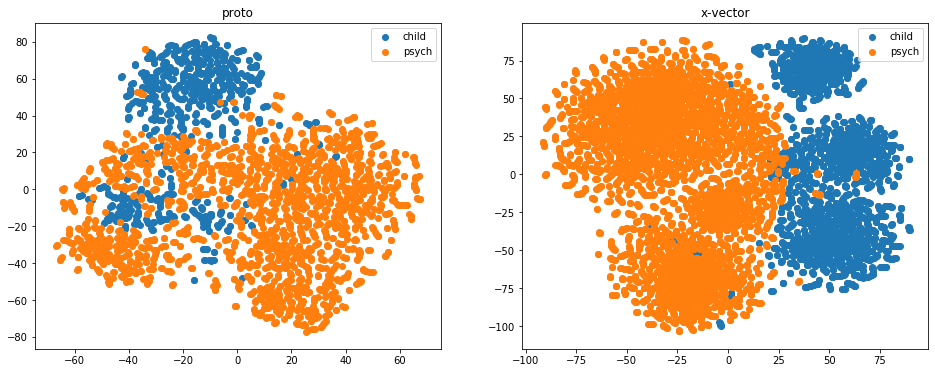

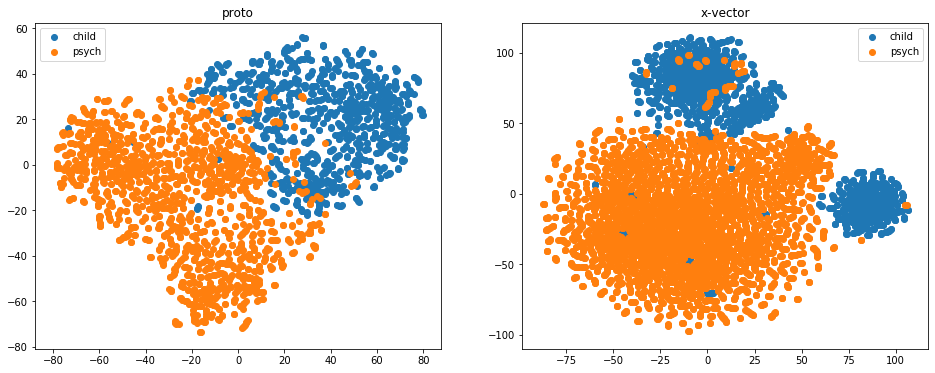

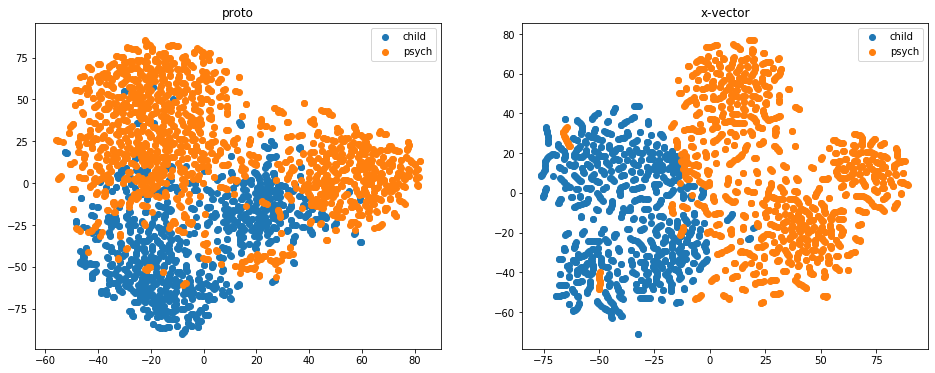

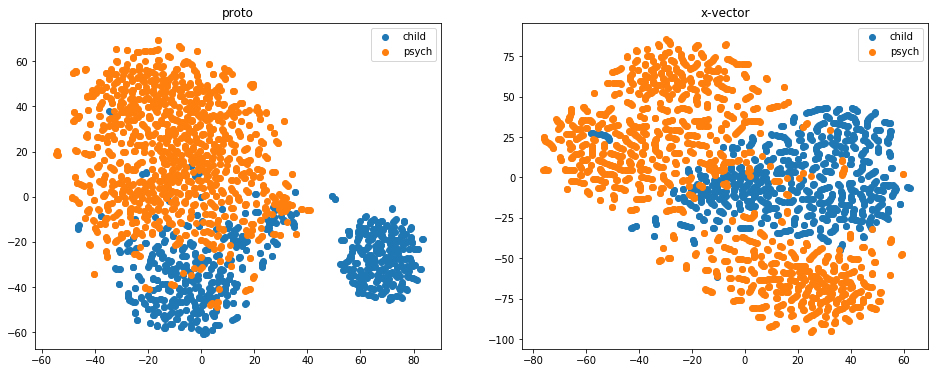

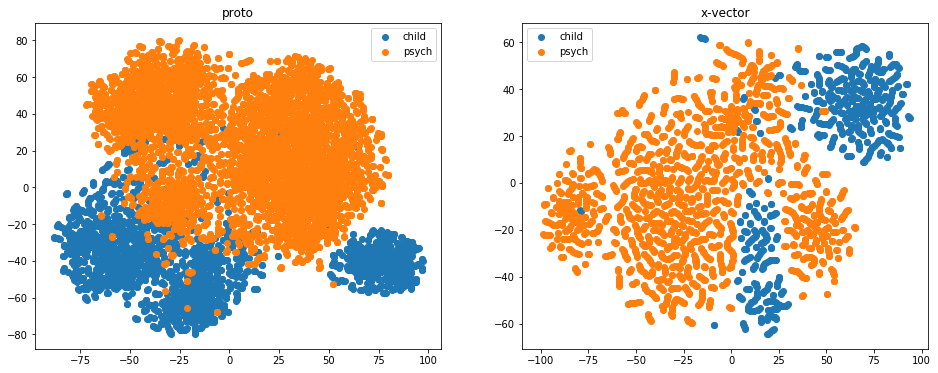

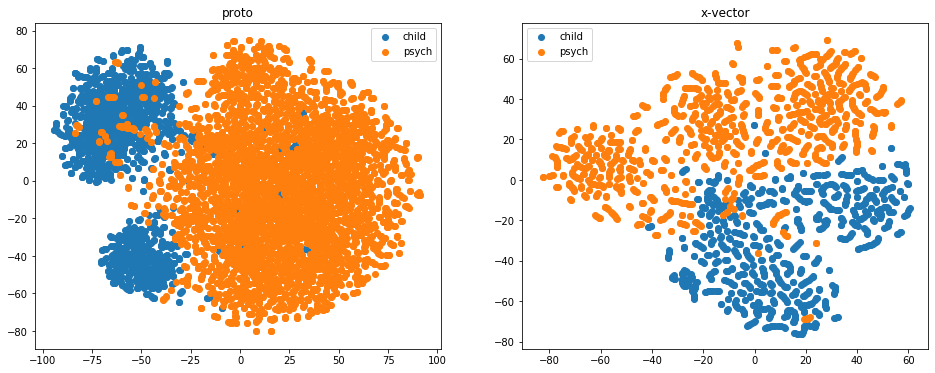

In [15]:
# for fold in range(9):
# for tfname in a.split():
for proto_per in [40]:
    for raw_per in [40]:
        for rand in range(4):
            for fold in range(9):
                tfname='new_B_128_train_shot_20_test_shot_5_train_epochs_200_test_epochs_1_beta_0.0'
                model = loadmodel(fold,baseline=False,dir=tfname)

                csv='folds/fold_{}/test.txt'.format((fold+4)%8)
                raw_data=[]
                Y_data=[]
                with open(csv,'r') as f:
                    for line in f.readlines():
                        name,speaker=line.split(',')
                        label=0 if speaker.split('_')[0]=='child' else 1
                        raw_data.append(np.load(name))
                        Y_data.append(label)

                X_data=[]
                model.eval()
                for i in raw_data:
                    out=model(torch.from_numpy(i).unsqueeze(0))
                    out=out.view(-1).detach().numpy()
                    X_data.append(out)

                assert len(X_data) == len(Y_data)
                Y_data=np.asarray(Y_data)
                path='folds/embeddings/{}/fold_{}/'.format(tfname,fold)
                if not os.path.exists(path):
                    os.makedirs(path)

            #     np.save(path+'X_embedd',X_data)
            #     np.save(path+'Y_embedd',Y_data)

                child_ids=np.argwhere(Y_data==0)
                psych_ids=np.argwhere(Y_data==1)

                X_embedded=TSNE(n_components=2,perplexity=proto_per).fit_transform(X_data)
                child_embeddings=X_embedded[child_ids].reshape(-1,2)
                psych_embeddings=X_embedded[psych_ids].reshape(-1,2)

                fig=plt.figure(figsize=(16,6))
                plt.subplot(1,2,1)
                plt.scatter(child_embeddings[:,0],child_embeddings[:,1])
                plt.scatter(psych_embeddings[:,0],psych_embeddings[:,1])
                plt.legend(['child','psych'])
                plt.title('proto'.format(fold))

                csv='folds/fold_{}/test.txt'.format(fold)
                raw_data=[]
                Y_data=[]
                with open(csv,'r') as f:
                    for line in f.readlines():
                        name,speaker=line.split(',')
                        label=0 if speaker.split('_')[0]=='child' else 1
                        raw_data.append(np.load(name))
                        Y_data.append(label)

                Y_data=np.asarray(Y_data)
                child_ids=np.argwhere(Y_data==0)
                psych_ids=np.argwhere(Y_data==1)
                X_embedded=TSNE(n_components=2,perplexity=raw_per).fit_transform(raw_data)
                child_embeddings=X_embedded[child_ids].reshape(-1,2)
                psych_embeddings=X_embedded[psych_ids].reshape(-1,2)

                plt.subplot(1,2,2)
                plt.scatter(child_embeddings[:,0],child_embeddings[:,1])
                plt.scatter(psych_embeddings[:,0],psych_embeddings[:,1])
                plt.legend(['child','psych'])
                plt.title('x-vector'.format(fold))
#                 plt.savefig('tsne/perplex_{}_{}_fold_{}_rand{}.png'.format(proto_per,raw_per,fold,rand))
                plt.show()